In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
# from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

import pickle
from spec_tools import Gen_SFH

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [9]:
min(mdb.query('Sigma1 > 10**10.25').z_50)

2.917489232868667

In [4]:
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()

Text(0,0.5,'EAZY lmass')

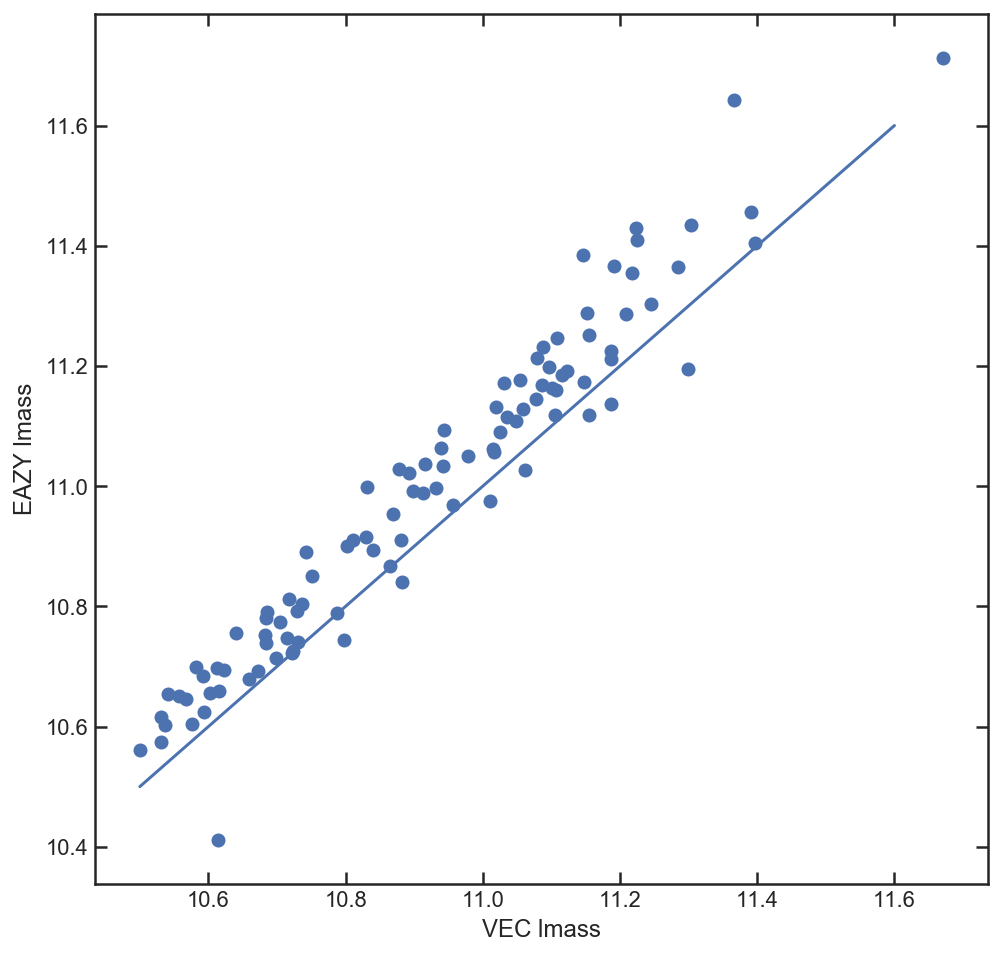

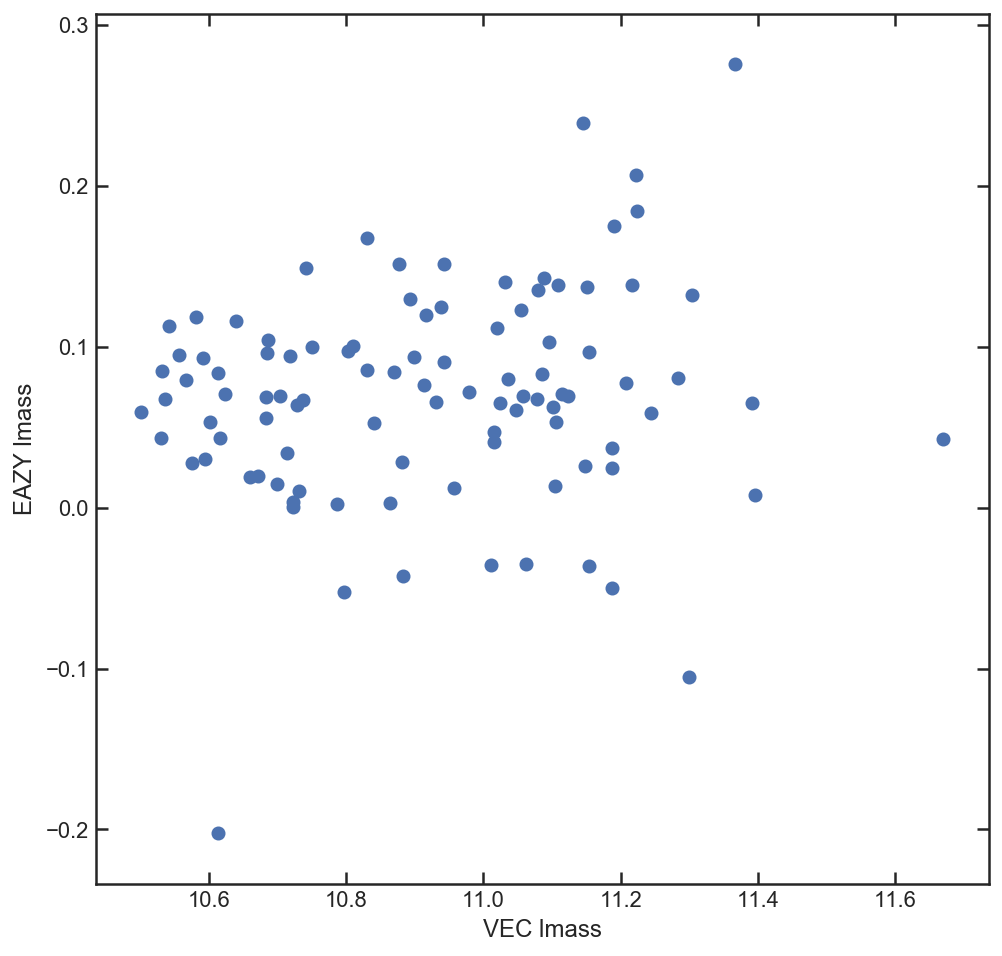

In [11]:

plt.figure(figsize=[8,8])
ax1 = plt.subplot()
ezmasses = []
for i in mdb.index:
    if mdb.field[i] == 'GSD':
        ezmass = np.log10(eazy_GSD.query('id == {}'.format(mdb.id[i])).mass.values[0])
    else:
        ezmass = np.log10(eazy_GND.query('id == {}'.format(mdb.id[i])).mass.values[0])      
    ezmasses.append(ezmass)

ezmasses = np.array(ezmasses)
    
ax1.scatter(mdb.lmass,ezmasses)

ax1.plot([10.5,11.6],[10.5,11.6])
ax1.set_xlabel('VEC lmass')
ax1.set_ylabel('EAZY lmass')


plt.figure(figsize=[8,8])
ax1 = plt.subplot()

ax1.scatter(mdb.lmass,ezmasses - mdb.lmass)
ax1.set_xlabel('VEC lmass')
ax1.set_ylabel('EAZY lmass')


In [14]:
offset = np.linspace(0.05,0.1)
chi2 = []
for i in offset:
    irange = interp1d(np.linspace(10,12), np.repeat(i, 50))
    
    chi2.append(sum(((ezmasses - mdb.lmass) - irange(mdb.lmass))**2))

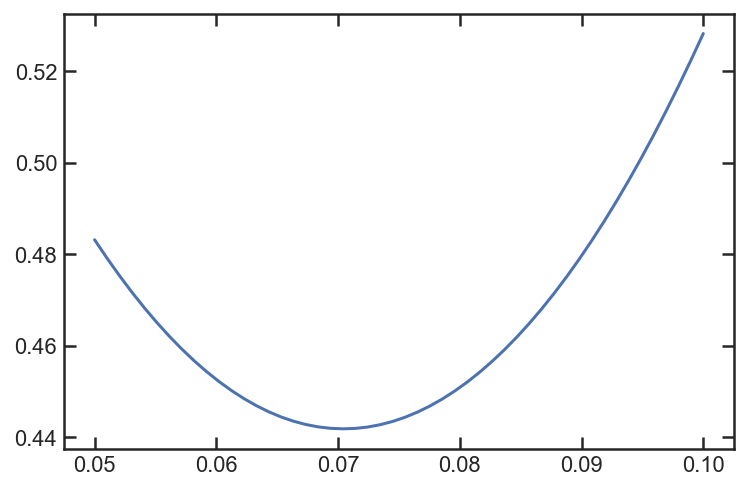

In [15]:
plt.plot(offset, chi2)

# Dust v SFR

In [37]:
sSFR = []

for idx in mdb.index:
    
    with open('../data/SFH/{}_{}_1D.pkl'.format( mdb.field[idx],  mdb.id[idx]), 'rb') as sfh_file:
        SFH = pickle.load(sfh_file)
    
    sSFR.append(np.log10((np.trapz(SFH.SFH[:11], SFH.LBT[:11])/0.1) / 10**mdb.lmass[idx]))

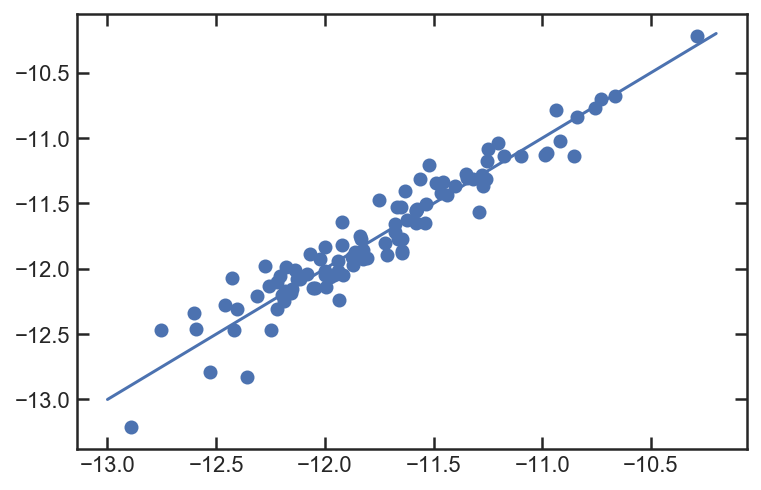

In [40]:
plt.scatter(sSFR, mdb.log_ssfr)
plt.plot([-13, -10.2],[-13, -10.2])

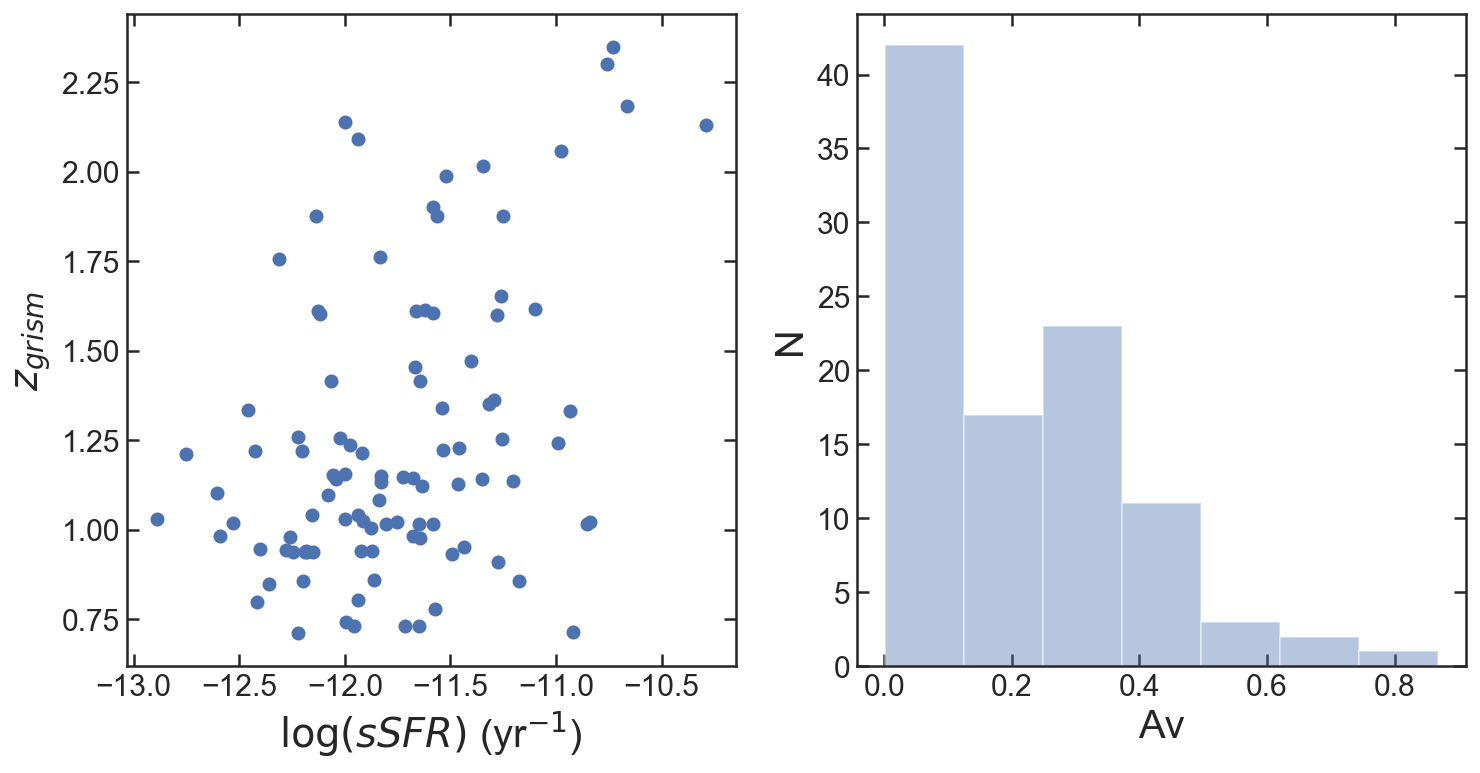

In [50]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize=[12,6])
ax1 = plt.subplot(gs[0])
plt.scatter(sSFR, mdb.zgrism)
ax2 = plt.subplot(gs[1])
sea.distplot(mdb.Av, kde =False)

ax1.set_xlabel('$\log(sSFR)$ (yr$^{-1}$)', fontsize=20)
ax2.set_xlabel('Av', fontsize=20)
ax1.set_ylabel('$z_{grism}$', fontsize=20)
ax2.set_ylabel('N', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/sSFR_Av.png', bbox_inches = 'tight')    


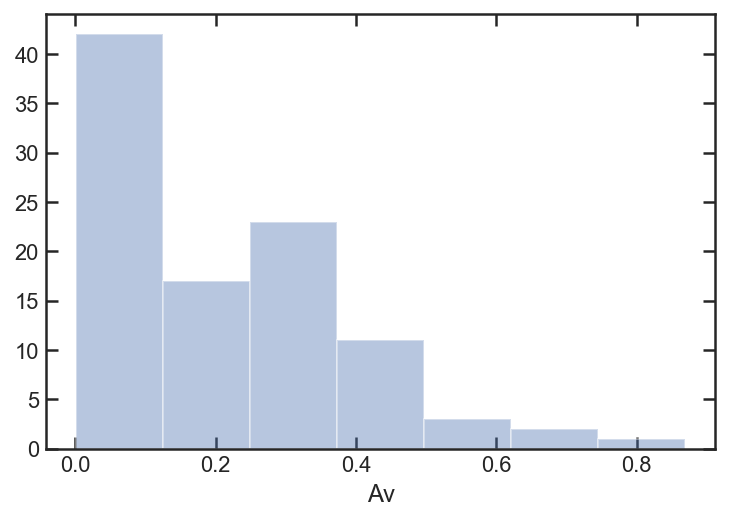

In [43]:
sea.distplot(mdb.Av, kde =False)

In [51]:
max(sSFR)

-10.290448267914766

# emission lines

In [16]:
swave, azflux, azerror = np.load('../data/plot_points/all_stacked.npy')

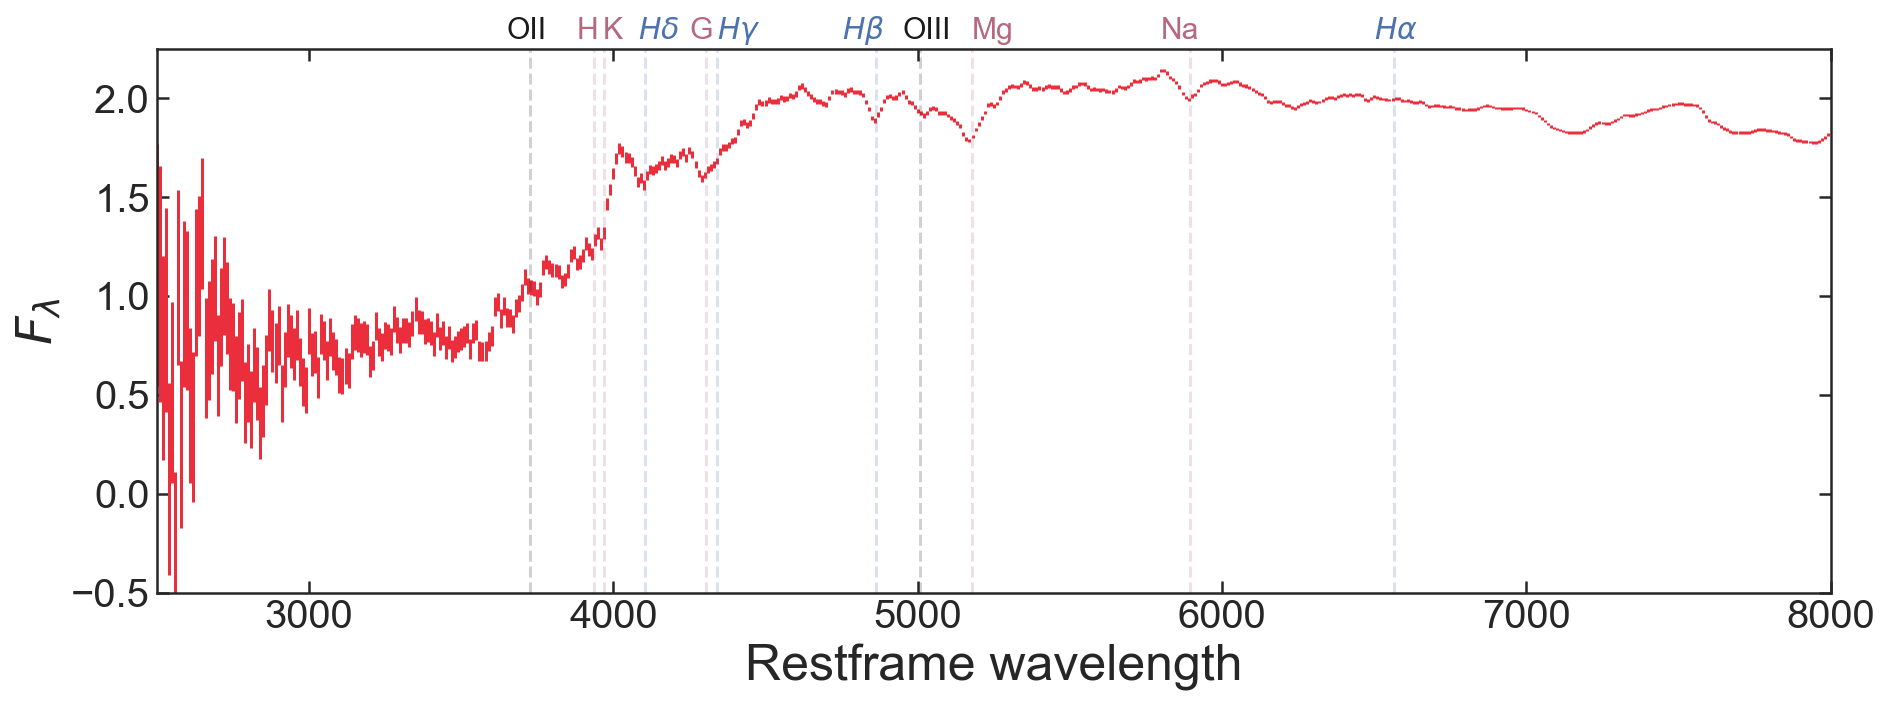

In [65]:
plt.figure(figsize=[15,5])

plt.errorbar(swave, azflux*1E3, azerror*1E3, linestyle = 'none', color='#EA2E3B',)

plt.axvline(3727 ,linestyle='--', color = 'k', alpha = 0.2)
plt.axvline(5008 ,linestyle='--', color = 'k', alpha = 0.2)

plt.axvline(3934.77 ,linestyle='--', color = '#B6687E', alpha = 0.2)
plt.axvline(3969.588 ,linestyle='--', color = '#B6687E', alpha = 0.2)
plt.axvline(4305.61 ,linestyle='--', color = '#B6687E', alpha = 0.2)
plt.axvline(5176.7,linestyle='--', color = '#B6687E', alpha = 0.2)
plt.axvline(5895.6,linestyle='--', color = '#B6687E', alpha = 0.2)

plt.axvline(4102.89 ,linestyle='--', color = 'b', alpha = 0.2)
plt.axvline(4341.68 ,linestyle='--', color = 'b', alpha = 0.2)
plt.axvline(4862.68 ,linestyle='--', color = 'b', alpha = 0.2)
plt.axvline(6564.61,linestyle='--', color = 'b', alpha = 0.2)

plt.ylabel('$F_\lambda$', fontsize=25)
plt.xlabel('Restframe wavelength', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(2500,8000)
plt.ylim(-0.5,2.25)

plt.text(3650, 2.3, 'OII', fontsize = 15, color = 'k')
plt.text(4950, 2.3, 'OIII', fontsize = 15, color = 'k')

plt.text(3880, 2.3, 'H', fontsize = 15, color = '#B6687E')
plt.text(3965, 2.3, 'K', fontsize = 15, color = '#B6687E')
plt.text(4250, 2.3, 'G', fontsize = 15, color = '#B6687E')
plt.text(5176.7, 2.3, 'Mg', fontsize = 15, color = '#B6687E')
plt.text(5800, 2.3, 'Na', fontsize = 15, color = '#B6687E')

plt.text(4080, 2.3, '$H\\delta$', fontsize = 15, color = 'b')
plt.text(4341.68, 2.3, '$H\\gamma$', fontsize = 15, color = 'b')
plt.text(4750, 2.3, '$H\\beta$', fontsize = 15, color = 'b')
plt.text(6500, 2.3, '$H\\alpha$', fontsize = 15, color = 'b')
plt.savefig('../plots/all_stack.png', bbox_inches = 'tight')

# table

In [56]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()

In [ ]:
allz = pd.read_pickle('../dataframes/galaxy_frames/all_redshifts.pkl')

zphot = []
zphot_16 = []
zphot_84 = []

for i in mdb.index:
    sml = allz.query('ID == {} and Field == "{}"'.format(alldb.id[i], alldb.field[i]))
    sml = sml.sort_values('red_CHI')
    
    zphot.append(sml.zphot_50.values[0])
    zphot_16.append(sml.zphot_16.values[0])
    zphot_84.append(sml.zphot_84.values[0])

zphot = np.array(zphot)
zphot_16 = np.array(zphot_16)
zphot_84 = np.array(zphot_84)

In [107]:
allz = pd.read_pickle('../dataframes/galaxy_frames/all_redshifts.pkl')

ra = []
dec = []
massez = []
lS1 = []
dS1 = []
zphot = []
zphot_16 = []
zphot_84 = []
t_q = []
t_qerr = []

for i in mdb.index:
    if mdb.field[i] == 'GND':
        ra.append(v4N.query('id == {}'.format(mdb.id[i])).ra.values[0] )
        dec.append(v4N.query('id == {}'.format(mdb.id[i])).dec.values[0] )     
        massez.append(np.log10(eazy_GND.query('id == {}'.format(mdb.id[i])).mass.values[0]))
    if mdb.field[i] == 'GSD':
        ra.append( v4S.query('id == {}'.format(mdb.id[i])).ra.values[0] )
        dec.append( v4S.query('id == {}'.format(mdb.id[i])).dec.values[0] )  
        massez.append(np.log10(eazy_GSD.query('id == {}'.format(mdb.id[i])).mass.values[0]))

    lS1.append(np.log10(mdb.Sigma1[i]))
    dS1.append(mdb.Sigma1_sig[i] / (mdb.Sigma1[i] * np.log(10)))

    sml = allz.query('ID == {} and Field == "{}"'.format(alldb.id[i], alldb.field[i]))
    sml = sml.sort_values('red_CHI')
    
    zphot.append(sml.zphot_50.values[0])
    zphot_16.append(sml.zphot_50.values[0] - sml.zphot_16.values[0])
    zphot_84.append(sml.zphot_84.values[0] - sml.zphot_50.values[0])

    t_q.append(mdb.t_50[i] - mdb.t_90[i])
    
    err = []
    for ii in range(2):
        err50 = np.abs(mdb.t_50[i] - mdb.t_50_hdr[i][ii])
        err90 = np.abs(mdb.t_90[i] - mdb.t_90_hdr[i][ii])
        
        err.append(np.sqrt(err50**2 + err90**2))
    t_qerr.append(err)

In [108]:
mdb['ra'] = ra
mdb['dec'] = dec
mdb['massez'] = massez
mdb['lS1'] = lS1
mdb['dS1'] = dS1
mdb['zphot'] = zphot
mdb['zphot_16'] = zphot_16
mdb['zphot_84'] = zphot_84
mdb['t_q'] = t_q
mdb['t_qerr'] = t_qerr
mdb['sSFR_m'] = sSFR
# ra dec zphot, zgrism, mass ez, mass r1/2, SFR, Av, z50, Sigma1, t_Q

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [81]:
mdb[['field', 'id', 'ra', 'dec', 'zphot', 'zphot_16', 'zphot_84', 'zgrism', 'zgrism_hdr', 'massez', 'lmass', 'lmass_hdr',\
    'Re', 'Re_sig', 'sSFR_m', 'log_ssfr_hdr', 'Av', 'Av_hdr', 'lS1', 'dS1', 't_q', 't_qerr']]

,field,id,ra,dec,zphot,zphot_16,zphot_84,zgrism,zgrism_hdr,massez,...,Re,Re_sig,sSFR_m,log_ssfr_hdr,Av,Av_hdr,lS1,dS1,t_q,t_qerr
2,GSD,40862,53.048020,-27.719743,1.341581,1.328374,1.358418,1.333095,"[1.3293190186710149, 1.3383820167162035]",11.185341,...,2.713480,0.027701,-10.934574,"[-10.922096377764401, -10.655386419021397]",0.454612,"[0.41118994718654833, 0.5034610756904888]",9.901061,0.019993,-1.511049,"[0.22217699190018492, 0.1467515382845418]"
10,GSD,39850,53.173100,-27.724355,0.955095,0.946396,0.966029,0.979554,"[0.9786141353946796, 0.9808485318372173]",10.691569,...,0.907649,0.010018,-12.258375,"[-12.687755282200474, -11.822859511170908]",0.036295,"[0.016803984115102012, 0.08158322099994794]",9.966326,0.019593,-1.847835,"[0.5754191259072191, 0.17137396177420114]"
14,GND,37186,189.243199,62.349892,0.804812,0.791553,0.820127,0.803694,"[0.8024745353841467, 0.8051371595533952]",10.989310,...,1.677268,0.026763,-11.936868,"[-12.554183537758721, -11.968374077661974]",0.009988,"[0.001831379718429112, 0.05776025457538027]",10.046497,0.023821,-1.356772,"[0.48794470659860545, 0.3651008700671391]"
17,GND,22358,189.081040,62.251545,0.817907,0.802848,0.833488,0.778565,"[0.7737427105702068, 0.7838246403150887]",10.713567,...,1.661192,0.016135,-11.573952,"[-11.713134531090367, -11.36000552040102]",0.182483,"[0.13058843847191903, 0.2603252190371288]",9.767972,0.030863,-1.883299,"[0.5810276688995484, 0.48648751693483433]"
19,GND,22246,189.220896,62.252424,0.874824,0.863355,0.884123,0.941617,"[0.9407654295467909, 0.942347469037385]",11.108726,...,3.580421,0.032012,-12.182614,"[-12.420156953252302, -11.923598731151914]",0.001428,"[0.0014278313927940918, 0.015083719903173266]",10.039211,0.014930,-2.227326,"[0.8554011248974759, 0.6031594512301106]"
24,GND,17746,189.049436,62.228979,1.161801,1.149230,1.178638,1.151755,"[1.1428952431606403, 1.1595073836113978]",11.127820,...,1.322862,0.040718,-12.055133,"[-12.588986889210982, -11.71359023500046]",0.349922,"[0.2603823958654308, 0.452891995598498]",10.239328,0.037884,-1.479628,"[0.6461199134695845, 0.40077211363646736]"
25,GSD,39631,53.042169,-27.725928,0.993757,0.979498,1.009822,1.028802,"[1.026126015837392, 1.0322913767301936]",10.991869,...,2.244815,0.026900,-12.890866,"[-13.600630361691952, -12.310258537452038]",0.249305,"[0.21795210285217748, 0.36359201614875625]",9.975111,0.020742,-0.863682,"[1.7712147490239212, 0.3528033358813842]"
33,GND,20432,189.362767,62.242309,1.136814,1.116000,1.156998,1.149262,"[1.1429843589349553, 1.1546101598920768]",11.063220,...,1.146548,0.014703,-11.826576,"[-12.177403382058525, -11.597479854005453]",0.192891,"[0.14370017474255065, 0.3188209737772886]",10.135053,0.027084,-1.494774,"[0.523645448025413, 0.4823720279837196]"
35,GSD,39012,53.064240,-27.727621,1.616861,1.581039,1.657225,1.612016,"[1.6068108934706729, 1.6176206058223757]",11.288514,...,1.624542,0.047002,-11.662104,"[-12.017776656309277, -11.56439028772684]",0.491376,"[0.4410732747103688, 0.561439774922537]",10.201679,0.019500,-0.330646,"[0.7965302805669697, 0.26547943100711696]"
37,GND,16758,189.162357,62.224840,0.981848,0.967393,0.996635,1.016235,"[1.0149490533572125, 1.0176335438819937]",11.050167,...,1.454510,0.014203,-11.650836,"[-11.87790662140134, -11.240479913132631]",0.563701,"[0.512329566425902, 0.6222407649997757]",10.067439,0.039248,-1.169849,"[0.6293573334100123, 0.5293908854997452]"


In [109]:
for idx in mdb.sort_values('zgrism').index:
    print('%s-%d & %f & %f & $%1.2f_{%1.2f}^{%1.2f}$ & $%1.3f_{%1.3f}^{%1.3f}$ & %1.2f & $%1.2f\
_{%1.2f}^{%1.2f}$ & %1.2f $\pm$ %1.2f & $%1.2f_{%1.2f}^{%1.2f}$ & $%1.2f_{%1.2f}^{%1.2f}$ \
& %1.2f $\pm$ %1.2f & $%1.2f_{%1.2f}^{%1.2f}$ \\\\' % (
    mdb.field[idx], mdb.id[idx], mdb.ra[idx], mdb.dec[idx], mdb.zphot[idx], mdb.zphot_16[idx], mdb.zphot_84[idx], mdb.zgrism[idx], 
    mdb.zgrism[idx]-mdb.zgrism_hdr[idx][0],mdb.zgrism_hdr[idx][1]-mdb.zgrism[idx], mdb.massez[idx], mdb.lmass[idx], 
    mdb.lmass[idx] - mdb.lmass_hdr[idx][0],mdb.lmass_hdr[idx][1]-mdb.lmass[idx],
    mdb.Re[idx], mdb.Re_sig[idx], mdb.sSFR_m[idx], np.abs(mdb.sSFR_m[idx]-mdb.log_ssfr_hdr[idx][0]), 
    np.abs(mdb.log_ssfr_hdr[idx][1]-mdb.sSFR_m[idx]), mdb.Av[idx], 
    mdb.Av_hdr[idx][0],mdb.Av_hdr[idx][1], mdb.lS1[idx], mdb.dS1[idx], mdb.t_q[idx], mdb.t_qerr[idx][0], mdb.t_qerr[idx][1]))

GND-29879 & 189.254227 & 62.291579 & $0.69_{0.01}^{0.01}$ & $0.711_{0.002}^{0.001}$ & 10.90 & $10.80_{0.03}^{0.04}$ & 1.12 $\pm$ 0.01 & $-12.22_{0.36}^{0.46}$ & $0.22_{0.14}^{0.30}$ & 9.99 $\pm$ 0.03 & $1.27_{0.75}^{0.43}$ \\
GND-21683 & 189.318225 & 62.253421 & $0.66_{0.01}^{0.01}$ & $0.715_{0.004}^{0.004}$ & 11.19 & $11.30_{0.03}^{0.03}$ & 6.73 $\pm$ 0.03 & $-10.92_{0.24}^{0.09}$ & $0.38_{0.31}^{0.45}$ & 10.21 $\pm$ 0.03 & $1.77_{0.67}^{0.41}$ \\
GSD-41147 & 53.081634 & -27.717718 & $0.70_{0.01}^{0.01}$ & $0.730_{0.002}^{0.002}$ & 10.80 & $10.74_{0.02}^{0.02}$ & 1.46 $\pm$ 0.01 & $-11.65_{0.42}^{0.02}$ & $0.20_{0.15}^{0.24}$ & 9.96 $\pm$ 0.02 & $2.48_{0.46}^{0.28}$ \\
GSD-47140 & 53.131853 & -27.687304 & $0.73_{0.01}^{0.01}$ & $0.731_{0.002}^{0.002}$ & 10.77 & $10.70_{0.02}^{0.03}$ & 2.91 $\pm$ 0.04 & $-11.96_{0.24}^{0.06}$ & $0.00_{0.00}^{0.02}$ & 9.71 $\pm$ 0.03 & $1.90_{1.07}^{0.37}$ \\
GSD-46001 & 53.120312 & -27.691486 & $0.72_{0.01}^{0.01}$ & $0.732_{0.001}^{0.001}$ & 11.16 & $

In [91]:
len([mdb.field[idx], mdb.id[idx], mdb.ra[idx], mdb.dec[idx], mdb.zphot[idx], mdb.zphot_16[idx], mdb.zphot_84[idx], mdb.zgrism[idx], 
    mdb.zgrism[idx] - mdb.zgrism_hdr[idx][0],mdb.zgrism_hdr[idx][1]-mdb.zgrism[idx], mdb.massez[idx], mdb.lmass[idx], mdb.lmass_hdr[idx][0],mdb.lmass_hdr[idx][1],
    mdb.Re[idx], mdb.Re_sig[idx], mdb.sSFR_m[idx], mdb.log_ssfr_hdr[idx][0], mdb.log_ssfr_hdr[idx][1], mdb.Av[idx], 
    mdb.Av_hdr[idx][0],mdb.Av_hdr[idx][1], mdb.lS1[idx], mdb.dS1[idx], mdb.t_q[idx], mdb.t_qerr[idx][0], mdb.t_qerr[idx][1]])

27

In [ ]:
'id', 'ra', 'dec', 'zphot', 'zgrism', 'massez', 'lmass', 'Re', 'sSFR_m', 'Av','lS1','t_q'

# sSFR selection

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('log_ssfr < -11 and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb2 = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


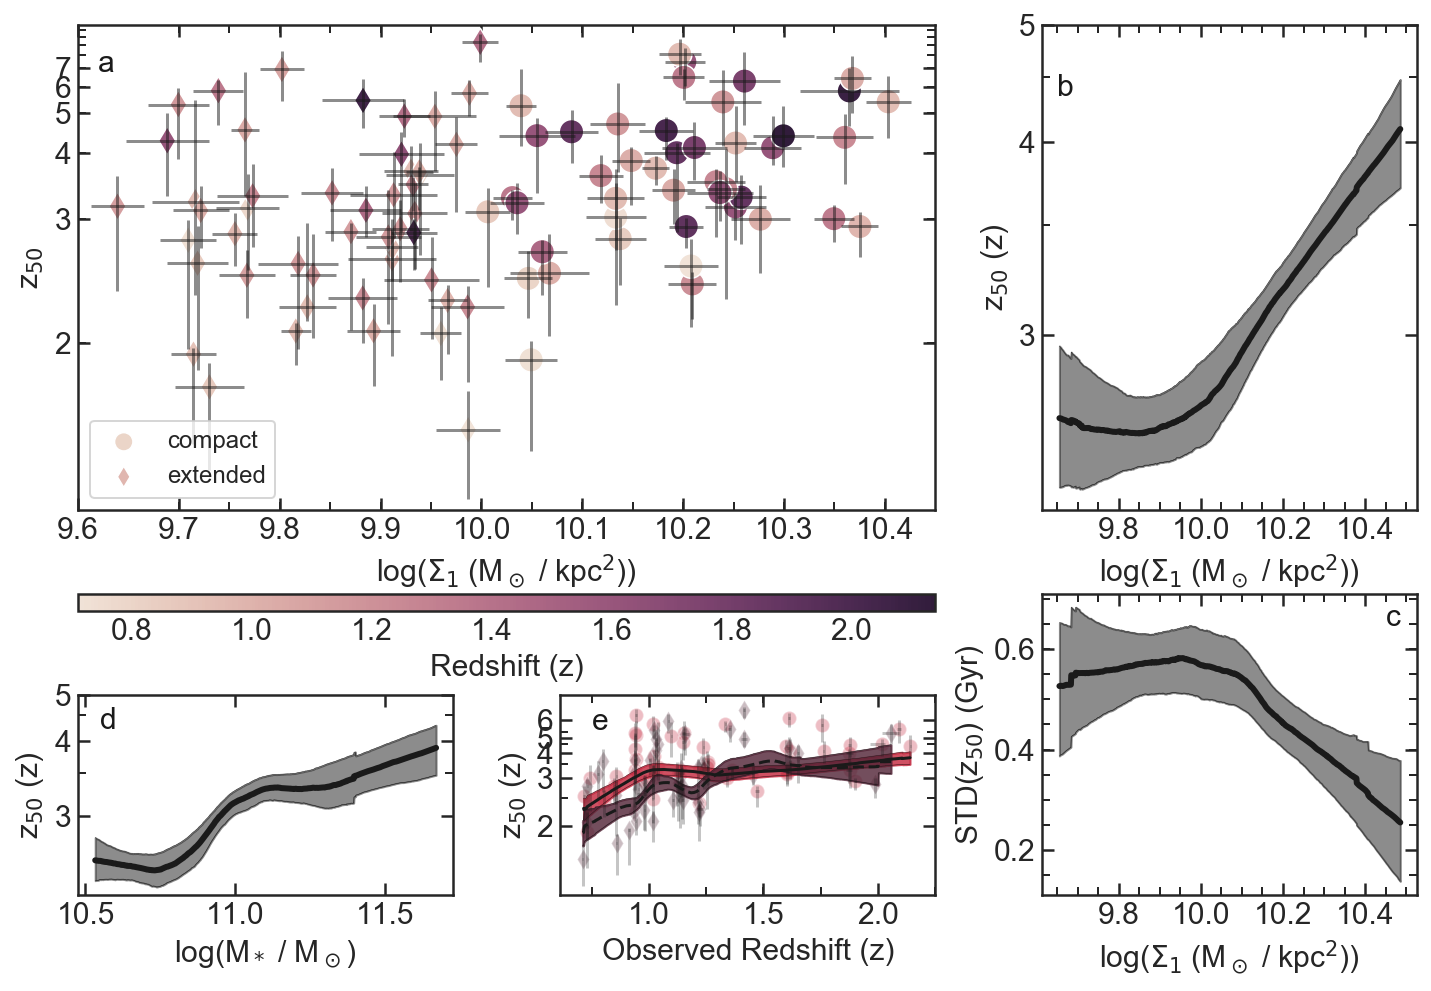

In [15]:
from matplotlib.patches import FancyBboxPatch
from matplotlib import cm
from matplotlib import colors
gs = gridspec.GridSpec(7,6,hspace=1.6,wspace=0.8, height_ratios=[1,1,1,1,.3,1,1])
cmap = sea.cubehelix_palette(light=0.9, as_cmap=True, start = 0.1)

plt.figure(figsize=[12,8])

ax1 = plt.subplot(gs[0:4,0:4])

sea.scatterplot(np.log10(mdb2.query('Sigma1 > 10**10').Sigma1), 
                cosmo.lookback_time(mdb2.query('Sigma1 > 10**10').z_50), legend=False, ax=ax1,
            alpha=1, s=150, hue = mdb2.query('Sigma1 > 10**10').zgrism, palette = cmap,
                hue_norm = (min(mdb2.zgrism),max(mdb2.zgrism)), label = 'compact')

sea.scatterplot(np.log10(mdb2.query('Sigma1 < 10**10').Sigma1), 
                cosmo.lookback_time(mdb2.query('Sigma1 < 10**10').z_50), legend=False, marker='d', ax=ax1,
            alpha=1, s=100, hue = mdb2.query('Sigma1 < 10**10').zgrism, palette = cmap,
                hue_norm = (min(mdb2.zgrism),max(mdb2.zgrism)), label = 'extended')

idx = 0
for i in mdb2.index:
    z50lerr = (cosmo.lookback_time(mdb2.z_50[i]) - cosmo.lookback_time(mdb2.z_50_hdr[i][0])).value
    z50herr = (cosmo.lookback_time(mdb2.z_50_hdr[i][1]) - cosmo.lookback_time(mdb2.z_50[i])).value

    plt.errorbar(np.log10(mdb2.Sigma1[i]), cosmo.lookback_time(mdb2.z_50[i]).value, 
                 xerr = mdb2.Sigma1_sig[i] / (mdb2.Sigma1[i] * np.log(10)), yerr = np.abs([[z50lerr], [z50herr]]), 
                 linestyle = 'none', alpha= 0.5, color = 'k')

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7]).value)
ax1.set_yticklabels([2,3,4,5,6,7])
ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,8,9,10,11]).value, minor=True)
ax1.set_ylim(cosmo.lookback_time(1.3).value,cosmo.lookback_time(12).value)
ax1.set_xticks(np.arange(10.4,9.7,-0.05), minor=True)
plt.xlim(9.6, 10.45)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=15)
plt.ylabel('z$_{50}$', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12, loc = 3, markerscale = 0.75)

############ B
ax2 = plt.subplot(gs[0:4,4:])
Sx_range, Sm, Sl, Sh = np.load('../data/plot_points/Sig1_lowess_ssfr.npy')

plt.plot(Sx_range[20:], Sm[20:], 'k', linewidth = 3)
plt.plot(Sx_range[20:], Sh[20:], 'k', linewidth = 0.2)
plt.plot(Sx_range[20:], Sl[20:], 'k', linewidth = 0.2)
plt.fill_between(Sx_range[20:], Sl[20:], Sh[20:], alpha = 0.5, color = 'k')

plt.ylabel('z$_{50}$ (z)', fontsize=15)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=15)
ax2.minorticks_on()
ax2.set_yticks(cosmo.lookback_time([3,4,5]).value)
ax2.set_yticklabels([3,4,5])
ax2.set_yticks(cosmo.lookback_time([3.5,4.5]).value, minor=True)
ax2.set_xticks([9.8,10,10.2,10.4])
plt.tick_params(axis='both', which='major', labelsize=15)

############ C

ax5 = plt.subplot(gs[4:,4:])

Sx_range, Sdm, Sdl, Sdh = np.load('../data/plot_points/Sig1_sd_lowess_ssfr.npy')

plt.plot(Sx_range[20:], Sdm[20:], 'k', linewidth = 3)
plt.plot(Sx_range[20:], Sdh[20:], 'k', linewidth = 0.2)
plt.plot(Sx_range[20:], Sdl[20:], 'k', linewidth = 0.2)
plt.fill_between(Sx_range[20:], Sdl[20:], Sdh[20:], alpha = 0.5, color = 'k')

plt.ylabel('STD(z$_{50}$) (Gyr)', fontsize=15)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
ax5.minorticks_on()
ax5.set_xticks([9.8,10,10.2,10.4])

############ D

ax3 = plt.subplot(gs[5:,2:4])
Cmdb = mdb2.query('Sigma1 > {0}'.format(10**10))
Emdb = mdb2.query('Sigma1 < {0}'.format(10**10))
sea.scatterplot(Cmdb.zgrism, cosmo.lookback_time(Cmdb.z_50),
            color = '#C4253C',ax = ax3, alpha=0.3, s=50)
sea.scatterplot(Emdb.zgrism, cosmo.lookback_time(Emdb.z_50),
            color = '#502234',ax = ax3, alpha=0.3, s=50, marker = 'd')

Cx_range, Cm, Cl, Ch = np.load('../data/plot_points/compact_lowess_ssfr.npy')
Ex_range, Em, El, Eh = np.load('../data/plot_points/extend_lowess_ssfr.npy')

plt.plot(Cx_range, Cm, 'k')
plt.plot(Cx_range, Ch, 'k', linewidth = 0.2)
plt.plot(Cx_range, Cl, 'k', linewidth = 0.2)
plt.fill_between(Cx_range, Cl, Ch, alpha = 0.8, color = '#C4253C')

plt.plot(Ex_range, Em, 'k--')
plt.plot(Ex_range, Eh, 'k', linewidth = 0.2)
plt.plot(Ex_range, El, 'k', linewidth = 0.2)
plt.fill_between(Ex_range, El, Eh, alpha = 0.8, color = '#502234')


idx = 0
for i in mdb2.index:
    z50lerr = (cosmo.lookback_time(mdb2.z_50[i]) - cosmo.lookback_time(mdb2.z_50_hdr[i][0])).value
    z50herr = (cosmo.lookback_time(mdb2.z_50_hdr[i][1]) - cosmo.lookback_time(mdb2.z_50[i])).value

    zlerr = (mdb2.zgrism[i] - mdb2.zgrism_hdr[i][0])
    zherr = (mdb2.zgrism_hdr[i][1] - mdb2.zgrism[i])
    
    plt.errorbar(mdb2.zgrism[i], cosmo.lookback_time(mdb2.z_50[i]).value, 
                 xerr = np.abs([[zlerr], [zherr]]), yerr = np.abs([[z50lerr], [z50herr]]), 
                 linestyle = 'none', alpha= 0.25, color = 'k')

ax3.set_xlabel('Observed Redshift (z)', fontsize=15)
ax3.set_ylabel('z$_{50}$ (z)', fontsize=15)

ax3.set_yticks(cosmo.lookback_time([2,3,4,5,7]).value)
ax3.set_yticklabels([2,3,4,5,6,7,9])
ax3.set_xticks([0.75, 1.25, 1.5,1.75, 2.25], minor = True)
# ax3.set_xlim(0.65,2.6)
ax3.set_yticks(cosmo.lookback_time([2.5,3.5,4.5,5.5]).value, minor=True)
plt.tick_params(axis='both', which='major', labelsize=15)

############ E
ax4 = plt.subplot(gs[5:,:2])
Mx_range, Mdm, Mdl, Mdh = np.load('../data/plot_points/mass_lowess_ssfr.npy')

plt.plot(Mx_range[27:], Mdm[27:], 'k', linewidth = 3)
plt.plot(Mx_range[27:], Mdh[27:], 'k', linewidth = 0.2)
plt.plot(Mx_range[27:], Mdl[27:], 'k', linewidth = 0.2)
plt.fill_between(Mx_range[27:], Mdl[27:], Mdh[27:], alpha = 0.5, color = 'k')

plt.ylabel('z$_{50}$ (z)', fontsize=15)
plt.xlabel('log(M$_*$ / M$_\odot$)', fontsize=15)
ax4.set_yticks(cosmo.lookback_time([3,4,5]).value)
ax4.set_yticklabels([3,4,5])
ax4.set_yticks(cosmo.lookback_time([3.5,4.5]).value, minor=True)
plt.tick_params(axis='both', which='major', labelsize=15)

ax1.text(9.62, 13.,'a', fontsize = 15, color = 'k')
ax2.text(9.65, 12.4,'b', fontsize = 15, color = 'k')
ax5.text(10.45, 0.645,'c', fontsize = 15, color = 'k')
ax3.text(0.75, 12.8,'e', fontsize = 15, color = 'k')
ax4.text(10.55, 12.35,'d', fontsize = 15, color = 'k',)

ax6 = plt.subplot(gs[4,0:4])
norm = mpl.colors.Normalize(vmin=min(mdb2.zgrism), vmax = max(mdb2.zgrism))
mpl.colorbar.ColorbarBase(ax6, cmap = cmap, norm=norm, orientation='horizontal')
ax6.set_xlabel('Redshift (z)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# ax6.yaxis.set_label_position('')

plt.savefig('../plots/compact_sig1_ssfr.png', bbox_inches = 'tight')

# isolation of galaxies

In [84]:
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()

In [88]:
def Match_galaxy_single(gal_db, gid):
    r = (1. / 60 / 60) * 1 

    gra = gal_db.query('id == {}'.format(gid)).ra.values[0]
    gdec = gal_db.query('id == {}'.format(gid)).dec.values[0]
    gz = gal_db.query('id == {}'.format(gid)).z500.values[0]
        
    cat_ra = gal_db.query('id != {}'.format(gid)).ra.values
    cat_dec = gal_db.query('id != {}'.format(gid)).dec.values
    cat_ids = gal_db.query('id != {}'.format(gid)).id.values
    cat_z = gal_db.query('id != {}'.format(gid)).z500.values
        
    cosr = np.sin(np.radians(gdec)) * np.sin(np.radians(cat_dec)) + np.cos(np.radians(gdec))\
            * np.cos(np.radians(cat_dec)) * np.cos(np.radians(gra) - np.radians(cat_ra))
    rad = np.arccos(cosr)
    rad = np.degrees(rad)

    cat_z -=gz

    rad[np.abs(cat_z) > 0.2] = 2000
    
#     print(cat_ids[rad == min(rad)])
#     print(min(rad)*60*60)
    return min(rad)*60*60

In [89]:
Match_galaxy_single(v4S, 39170)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


1.114165069606391

In [90]:
msep = []
for i in mdb.index:
    if mdb.field[i] == 'GND':
        msep.append(Match_galaxy_single(v4N,mdb.id[i]))
    else:
        msep.append(Match_galaxy_single(v4S,mdb.id[i]))
        

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


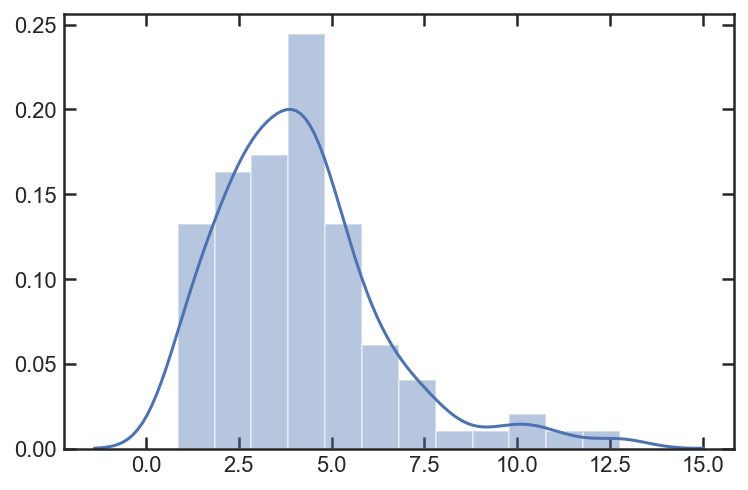

In [91]:
sea.distplot(msep)

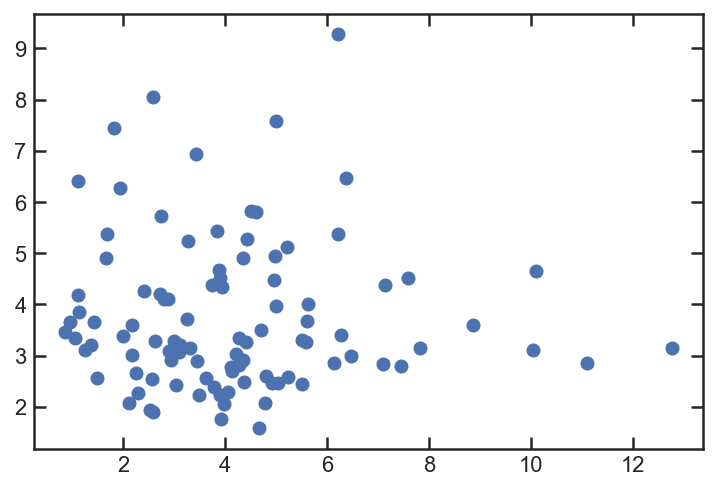

In [95]:
plt.scatter(msep, mdb.z_50)

# Merger rate

In [17]:
from spec_stats import Leave_one_out
def Sum_SFH(lbt, sfh):
    return np.sum(SFH_grid, axis=0)

def Sum_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    dt_bs = []
    w = Leave_one_out(np.array(sfh), lbt)
    wsfh = [w[U]*sfh[U] for U in range(len(sfh))]
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))            
        S= np.sum(np.array(wsfh)[IDX], axis=0)
        istack = interp1d(lbt,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)
        iT = interp1d(np.cumsum(istack[::-1]) / np.cumsum(istack[::-1])[-1], lbt - min(lbt))
        dt_bs.append(iT(0.9) - iT(0.5))
        
    sfh_bs = np.array(sfh_bs)
    dt_bs = np.array(dt_bs)
    
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    DT = np.percentile(dt_bs,50)
    DT16 = np.percentile(dt_bs,16)
    DT84 = np.percentile(dt_bs,84)
            
    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84, DT, DT16, DT84

def dt_sfh(tau,t, n = 1):
    sfh = t*np.exp(-t/tau)
    return sfh / np.trapz(sfh,t) * n

def t_star(SFH, TIME, starval):
    iT = interp1d(np.cumsum(SFH) / np.cumsum(SFH)[-1],T)
    return iT(starval)

def sfh_shift_rand(SFH, TIME):
    shift = int(np.random.choice(np.arange(0,2.5,0.1)) / 0.01)
    SFH_shift = np.append(np.zeros(shift), SFH)[:-shift]
    return SFH_shift / np.trapz(SFH_shift,TIME)

In [18]:
S1db = mdb.query('z_50 > 2.9').sort_values('Sigma1')

import pickle
from make_sfh_tool import Gen_SFH

idx = 0
LBT = np.linspace(0,14, 1000)
L=[]
S=[]
Sl=[]
Sh=[]
DT=[]
DTl=[]
DTh=[]

Sig1 = []
M = []
while idx < len(S1db.index)-14:
    SFH_grid = []
    s1_grid = []
    M_grid = []
    for i in S1db.index[idx:idx + 15]:
        try:
            lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(S1db.field[i], S1db.id[i]))
            
        except:
            try:
                with open('../data/SFH/{}_{}.pkl'.format(S1db.field[i], S1db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH 
                
            except:
                with open('../data/SFH/{}_{}_1D.pkl'.format(S1db.field[i], S1db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH                
                
        isfh = interp1d(lbt+cosmo.lookback_time(S1db.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
#         SFH_grid.append(isfh/ np.trapz(isfh, LBT))
        SFH_grid.append(isfh)
        s1_grid.append(S1db.Sigma1[i])
        M_grid.append(10**S1db.lmass[i])
    
#     L1,S1,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its=50)
    L1,S1,S16,S84,dt, dt16, dt84  = Sum_SFH_bs(LBT, SFH_grid)
    L.append(L1)
    S.append(S1)
    Sl.append(S16)
    Sh.append(S84)
    DT.append(dt)
    DTl.append(dt16)
    DTh.append(dt84)
    
    Sig1.append(np.mean(s1_grid))
    M.append(np.mean(M_grid))
    
    idx+=1

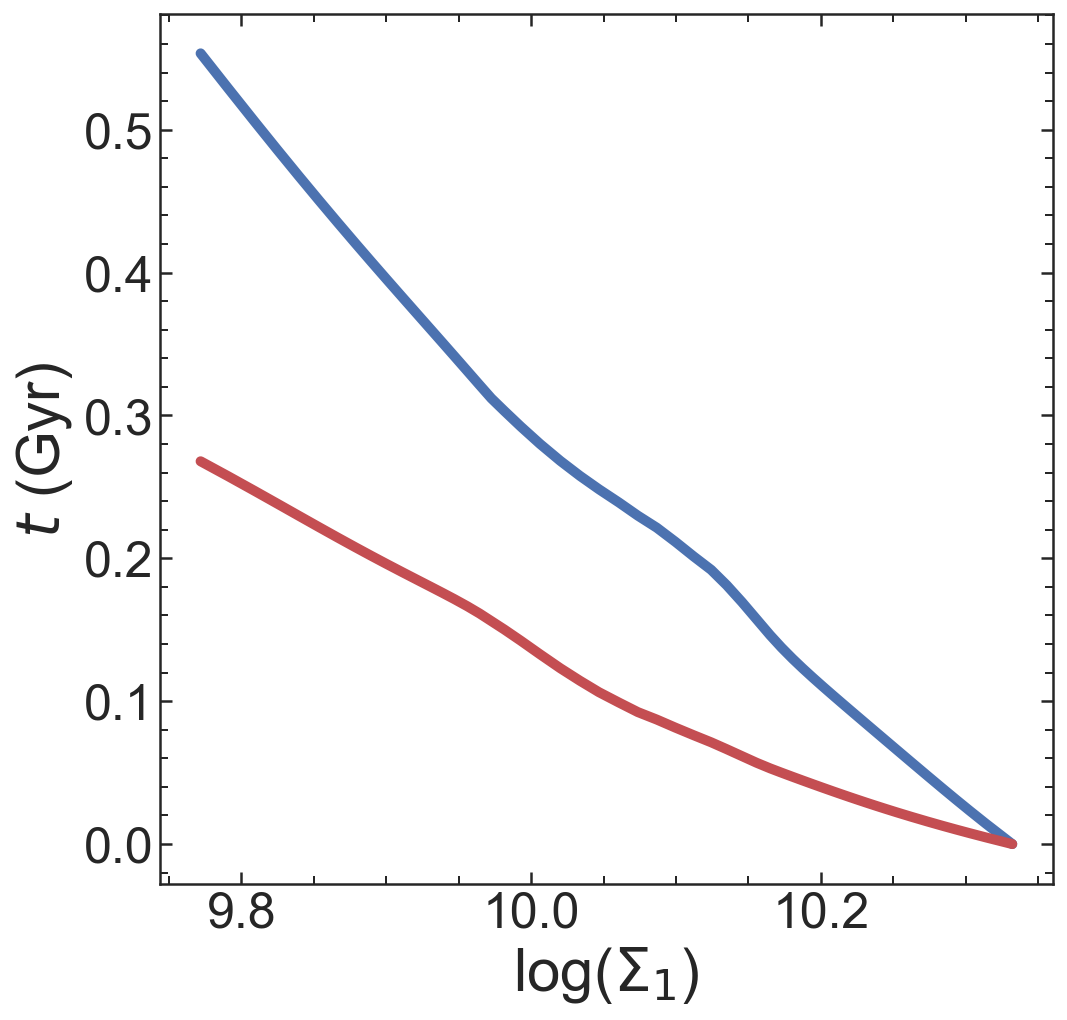

In [34]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

plt.figure(figsize=[8,8])
ax3 = plt.subplot()
dt50 = []
dtq = []


for i in range(len(L)):
    iT = interp1d(np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],L[i] - min(L[i]))
    dtq.append(iT(0.9)-iT(0.5))
    dt50.append(iT(0.5))

Q = lowess(dtq, np.log10(Sig1))
plt.plot(Q[:, 0], Q[:, 1] - Q[:,1][-1], linewidth=5, color = 'b')
 
fif = lowess(dt50,np.log10(Sig1))
plt.plot(fif[:, 0], fif[:, 1] - fif[:,1][-1], linewidth=5, color = 'r')
    
# sea.scatterplot(np.log10(Sig1), dtq)
# sea.scatterplot(np.log10(Sig1), dt50)
    
ax3.set_ylabel('$t$ (Gyr)', fontsize=30)
ax3.set_xlabel('log($\Sigma_1$)', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=25)


In [38]:
Q[:, 1] - Q[:,1][-1]

array([0.55346095, 0.52888455, 0.5056534 , 0.4861867 , 0.46763493,
       0.45074513, 0.43476465, 0.42033621, 0.40769422, 0.39552336,
       0.38280343, 0.37028763, 0.35998142, 0.35092501, 0.34154261,
       0.33116194, 0.3213509 , 0.31199158, 0.3030727 , 0.29225697,
       0.28010535, 0.26821502, 0.25772005, 0.24834541, 0.23911302,
       0.22987656, 0.22142079, 0.21150074, 0.20130648, 0.19194045,
       0.1811856 , 0.16935664, 0.15725618, 0.14626404, 0.13762082,
       0.12982079, 0.12312554, 0.1166057 , 0.11028951, 0.10424329,
       0.09863746, 0.09373986, 0.08926289, 0.08423189, 0.07865994,
       0.07263999, 0.06612284, 0.05724422, 0.04793274, 0.03899187,
       0.03117768, 0.02334384, 0.01415875, 0.        ])

In [70]:
T = np.arange(0,5.8,0.01)
gs = gridspec.GridSpec(1,2)
merges = []
d_dt = []

for xx in range(1000):
    SFH = dt_sfh(np.random.choice(np.arange(0.01,0.6,0.01)),T)
    t50 = t_star(SFH, T, 0.5)
    t90 = t_star(SFH, T, 0.9)
    dt = t90 - t50

    dt50 = 0
    dtdt = 0
    x=0


    while dt50 < 0.55:
        sfh = dt_sfh(np.random.choice(np.arange(0.01,3,0.01)) ,T,np.random.choice(np.arange(0.1,0.25,0.001)))
        SFH += sfh

        t50_2 = t_star(SFH, T, 0.5)
        t90_2 = t_star(SFH, T, 0.9)
        dt_2 = t90_2 - t50_2
        dt50 = t50_2 - t50
        dtdt = dt_2 - dt

        x+=1
    merges.append(x)
    d_dt.append(dtdt)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


7.0 11.0 17.0
1.7261142210699778 2.357769689215954 3.0543328976093345


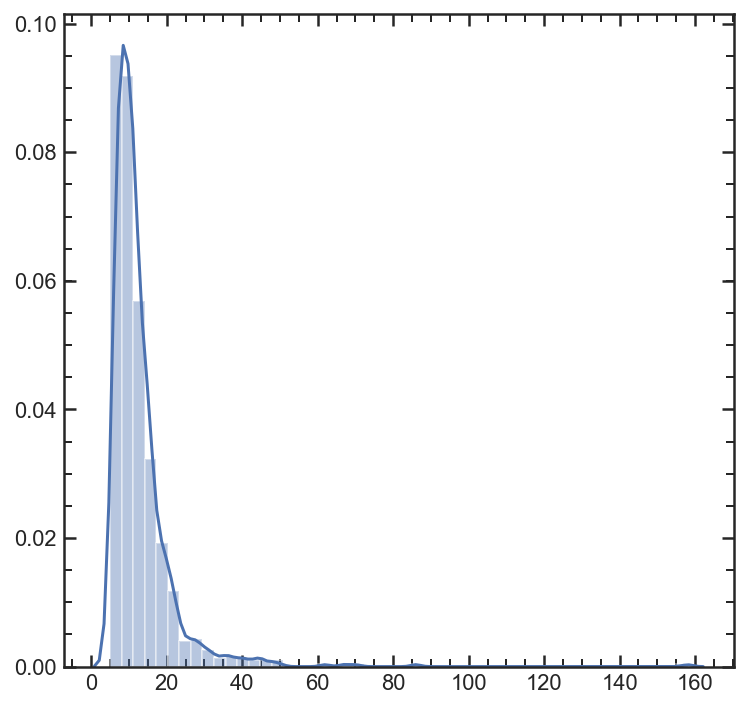

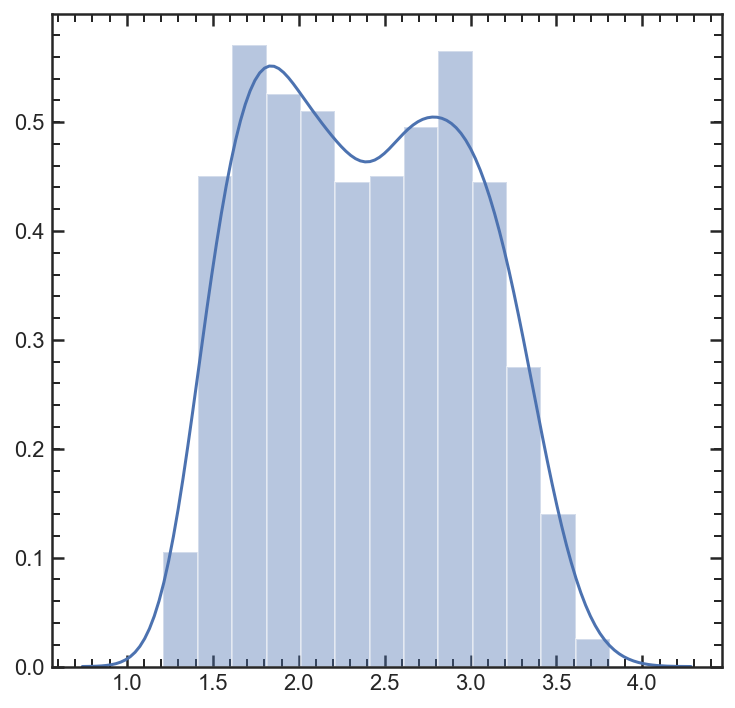

In [71]:
plt.figure(figsize=[6,6])
sea.distplot(merges)
plt.figure(figsize=[6,6])
sea.distplot(d_dt)

print(np.percentile(merges,16),np.percentile(merges,50),np.percentile(merges,84))
print(np.percentile(d_dt,16),np.percentile(d_dt,50),np.percentile(d_dt,84))

In [107]:
T = np.arange(0,5.8,0.01)

d_t50 = []
d_dt = []

for x in range(1000):
    SFH = dt_sfh(np.random.choice(np.arange(0.01,0.6,0.01)),T)
    t50 = t_star(SFH, T, 0.5)
    t90 = t_star(SFH, T, 0.9)
    dt = t90 - t50
    
    mergers = np.random.choice(np.arange(0,9).astype(int))
    
    for x in range(mergers):
        sfh = dt_sfh(np.random.choice(np.arange(0.01,3,0.01)) ,T,0.1)
        SFH += sfh

    t50_2 = t_star(SFH, T, 0.5)
    t90_2 = t_star(SFH, T, 0.9)
    dt_2 = t90_2 - t50_2

    d_t50.append(x)
    d_dt.append(dt_2 - dt)

In [ ]:
import scipy.optimize

# plt.figure(figsize = [8,8])
# sea.scatterplot(d_t50, d_dt, label = 'minor')
# sea.scatterplot(D_t50, D_dt, label = 'major')
# plt.xlabel('$\Delta t_{50}$ (Gyr)', fontsize=25)
# plt.ylabel('$\Delta t_{Q}$ (Gyr)', fontsize=25)
# plt.tick_params(axis='both', which='major', labelsize=20)
# plt.legend(loc = 2, fontsize = 20)


plt.figure(figsize=[8,8])

plt.errorbar(np.percentile(D_t50,50),np.percentile(D_dt,50),
            xerr =  [[np.percentile(D_t50,50) - np.percentile(D_t50,16)], [np.percentile(D_t50,84) - np.percentile(D_t50,50)]],
            yerr =  [[np.percentile(D_dt,50) - np.percentile(D_dt,16)], [np.percentile(D_dt,84) - np.percentile(D_dt,50)]], 
            linewidth = 5, label = 'major', barsabove = True, capsize = 10, color = 'r')

plt.errorbar(np.percentile(d_t50,50),np.percentile(d_dt,50),
            xerr =  [[np.percentile(d_t50,50) - np.percentile(d_t50,16)], [np.percentile(d_t50,84) - np.percentile(d_t50,50)]],
            yerr =  [[np.percentile(d_dt,50) - np.percentile(d_dt,16)], [np.percentile(d_dt,84) - np.percentile(d_dt,50)]], 
            linewidth = 5, label = 'minor', barsabove = True, capsize = 10, color = 'b')

plt.xlim(-0.5,0.5)
plt.ylim(-0.3,2.4)

plt.xlabel('$\Delta t_{50}$ (Gyr)', fontsize=25)
plt.ylabel('$\Delta t_{Q}$ (Gyr)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.annotate('minor\nmergers', xy=(0.1, 1.),  xycoords='data',
            xytext=(0.3, 1.5), textcoords='data',
            arrowprops=dict(facecolor='b', shrink=0.05),
            horizontalalignment='left', verticalalignment='top', fontsize = 20
            )

plt.annotate('major\nmergers', xy=(-0.025, .1),  xycoords='data',
            xytext=(-.3, .5), textcoords='data',
            arrowprops=dict(facecolor='r', shrink=0.05),
            horizontalalignment='left', verticalalignment='top', fontsize = 20
            )

# plt.savefig('../plots/mergers_aas.png', bbox_inches = 'tight')